In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
import pickle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
region = 'ouaga'
sahel = [-12,12,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':sahel, 'ouaga':ouaga, 'niamey':niamey, 'timbuktu':timbuktu}
domain = regions[region]


fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_'+region+'.p', "rb")) #'+region+'
#ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_sahel.p', "rb")) #'+region+'

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  np.array(ftcw['rel']) 

precip_all = ftcw['prcp_hist']

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

In [4]:
print('Shear scaling', shearfac)
print('TCW scaling', tcwvfac_all)

Shear scaling 0.795388088560751
TCW scaling [1.16683393 1.06097084 1.16683393 1.77577425 1.74989592]


In [5]:
ftcw

{'rel': array([1.16683393, 1.06097084, 1.16683393, 1.77577425, 1.74989592]),
 'abs': [0.7818229379777575,
  1.004446578150759,
  1.0731134418237924,
  1.5174331327959532,
  1.3843270036477613],
 'tcw_hist': array([34.  , 40.94, 43.94, 46.56, 54.14]),
 'prcp_hist': [34.93597281837878,
  38.75888144484652,
  40.41072474827086,
  39.78641234923386,
  42.8296694298488],
 'tcw_fut': array([51.01, 59.96, 63.6 , 67.05, 74.93]),
 'prcp_fut': [48.23478099338043,
  57.863455361273964,
  61.50813501452662,
  70.87861724022294,
  71.60982783568576]}

In [6]:
def calc_mcs_stuff(dic, domain):
    m1=7
    m2=9

    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    
    return dicout

In [7]:
#print(' Ouaga fraction MCS with TCW < maxPrecip Hist / Fut', np.sum(cp4hist_mcs95['tcwv']<cp4hist_mcs95['prcp'])/np.sum(np.isfinite(cp4hist_mcs95['prcp']))*100, np.sum(cp4fut_mcs95['tcwv']<cp4fut_mcs95['prcp'])/np.sum(np.isfinite(cp4fut_mcs95['prcp']))*100 )

In [8]:
dd = domain#[-10,15,9,19]
obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

obs_mcs95_prange = calc_mcs_stuff(obs_mcs_d, dd).quantile([0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.95,0.975,0.99])
cp4hist_mcs95_prange = calc_mcs_stuff(cp4hist_mcs_d, dd).quantile([0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.95,0.975,0.99])
cp4fut_mcs95_prange = calc_mcs_stuff(cp4fut_mcs_d, dd).quantile([0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.95,0.975,0.99])

In [9]:
cp4fut_mcs95_prange.prcp

0.010     0.689503
0.050     2.907770
0.100     6.087576
0.150     9.313648
0.200    13.497677
0.250    17.807724
0.300    20.313793
0.350    23.260387
0.400    26.107482
0.450    30.323099
0.500    33.530824
0.550    35.981249
0.600    39.205460
0.650    43.163300
0.700    46.575990
0.750    50.165161
0.800    54.284850
0.850    58.920548
0.950    75.219129
0.975    84.432176
0.990    91.379411
Name: prcp, dtype: float64

1.844588914154943
1.9838392582980107
1.7695171705437869


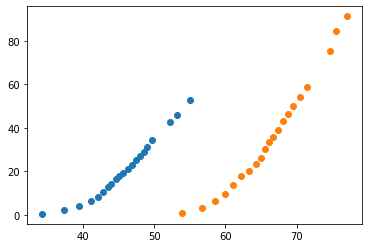

In [10]:
plt.scatter(cp4hist_mcs95_prange.tcwv, cp4hist_mcs95_prange.prcp)
plt.scatter(cp4fut_mcs95_prange.tcwv, cp4fut_mcs95_prange.prcp)
print(((cp4fut_mcs95_prange.prcp[0.99]-cp4hist_mcs95_prange.prcp[0.99])/cp4hist_mcs95_prange.prcp[0.99])/  ((cp4fut_mcs95_prange.tcwv[0.99]-cp4hist_mcs95_prange.tcwv[0.99])/cp4hist_mcs95_prange.tcwv[0.99]) )
print(((cp4fut_mcs95_prange.prcp[0.975]-cp4hist_mcs95_prange.prcp[0.975])/cp4hist_mcs95_prange.prcp[0.975])/  ((cp4fut_mcs95_prange.tcwv[0.975]-cp4hist_mcs95_prange.tcwv[0.975])/cp4hist_mcs95_prange.tcwv[0.975]) )
print(((cp4fut_mcs95_prange.prcp[0.95]-cp4hist_mcs95_prange.prcp[0.95])/cp4hist_mcs95_prange.prcp[0.95])/  ((cp4fut_mcs95_prange.tcwv[0.95]-cp4hist_mcs95_prange.tcwv[0.95])/cp4hist_mcs95_prange.tcwv[0.95]) )

In [11]:
print((cp4fut_mcs95_prange.prcp[0.99]-cp4hist_mcs95_prange.prcp[0.99]),  (cp4fut_mcs95_prange.tcwv[0.99]-cp4hist_mcs95_prange.tcwv[0.99]), cp4hist_mcs95_prange.tcwv[0.99])
print((cp4fut_mcs95_prange.prcp[0.975]-cp4hist_mcs95_prange.prcp[0.975]),  (cp4fut_mcs95_prange.tcwv[0.975]-cp4hist_mcs95_prange.tcwv[0.975]) , cp4hist_mcs95_prange.tcwv[0.975]) 
print((cp4fut_mcs95_prange.prcp[0.95]-cp4hist_mcs95_prange.prcp[0.95]), (cp4fut_mcs95_prange.tcwv[0.95]-cp4hist_mcs95_prange.tcwv[0.95]), cp4hist_mcs95_prange.tcwv[0.95])

38.71807558912612 21.94664290669794 55.061216164105964
38.310436501915454 22.282518967856674 53.21809725407179
32.45311884199123 22.39867379090952 52.22992182938345


In [12]:
cp4hist_mcs95 = calc_mcs_stuff(cp4hist_mcs_d, dd)
cp4fut_mcs95= calc_mcs_stuff(cp4fut_mcs_d, dd)
tcw975h = cp4hist_mcs95.quantile([0.95]).tcwv
tcw975f = cp4hist_mcs95.quantile([0.95]).tcwv

In [13]:
prcph = cp4hist_mcs95.prcp[cp4hist_mcs95.tcwv > tcw975h[0.95]].quantile(0.95)
prcpf = cp4fut_mcs95.prcp[cp4fut_mcs95.tcwv > tcw975f[0.95]].quantile(0.95)

In [14]:
prcpf-prcph

27.75576748564052

In [15]:
def calc_regional(dd):

    cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    cp4_tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    
    cp4_u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    cp4_u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    cp4_u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    cp4_u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    
    cp4_shear_hist = cp4_u925_hist-cp4_u600_hist
    cp4_shear_fut = cp4_u925_fut-cp4_u600_fut
    
    cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist
    cp4_tcw = (cp4_tcw_fut-cp4_tcw_hist)
    
    cp4_shear_abs = cp4_shear_fut-cp4_shear_hist
    
    return cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs

In [16]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()

In [17]:
model_names = cmip_tcw_map.model_name

In [23]:
def calc_mcs(dd):

    obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
    cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
    cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

    obs_mcs95 = calc_mcs_stuff(obs_mcs_d, dd).quantile(0.95)
    cp4hist_mcs95 = calc_mcs_stuff(cp4hist_mcs_d, dd).quantile(0.95)
    cp4fut_mcs95 = calc_mcs_stuff(cp4fut_mcs_d, dd).quantile(0.95)
    
    return cp4hist_mcs95, cp4fut_mcs95, obs_mcs95

TCWV rel ouaga 0.46091136 0.42884754574356837
TCWV ABS difference ouaga 21.224487 22.39867379090952
TCWV hist ouaga 46.048958 52.22992182938345
PRCP ouaga 0.7588530957388063


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

38.547149816792114 18.06076896194385
TCWV rel niamey 0.49940246 0.4236393237817544
TCWV ABS difference niamey 22.03357 22.04471693506234
TCWV hist niamey 44.119865 52.03652186551757
PRCP niamey 0.6975369352914068


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

40.9885307384847 23.676629871501255
TCWV rel timbuktu 0.54614025 0.43189302765959625
TCWV ABS difference timbuktu 19.580826 21.38181921670997
TCWV hist timbuktu 35.853107 49.50721092344749
PRCP timbuktu 0.6697325085124006


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

30.889166243473593 19.358187947976013


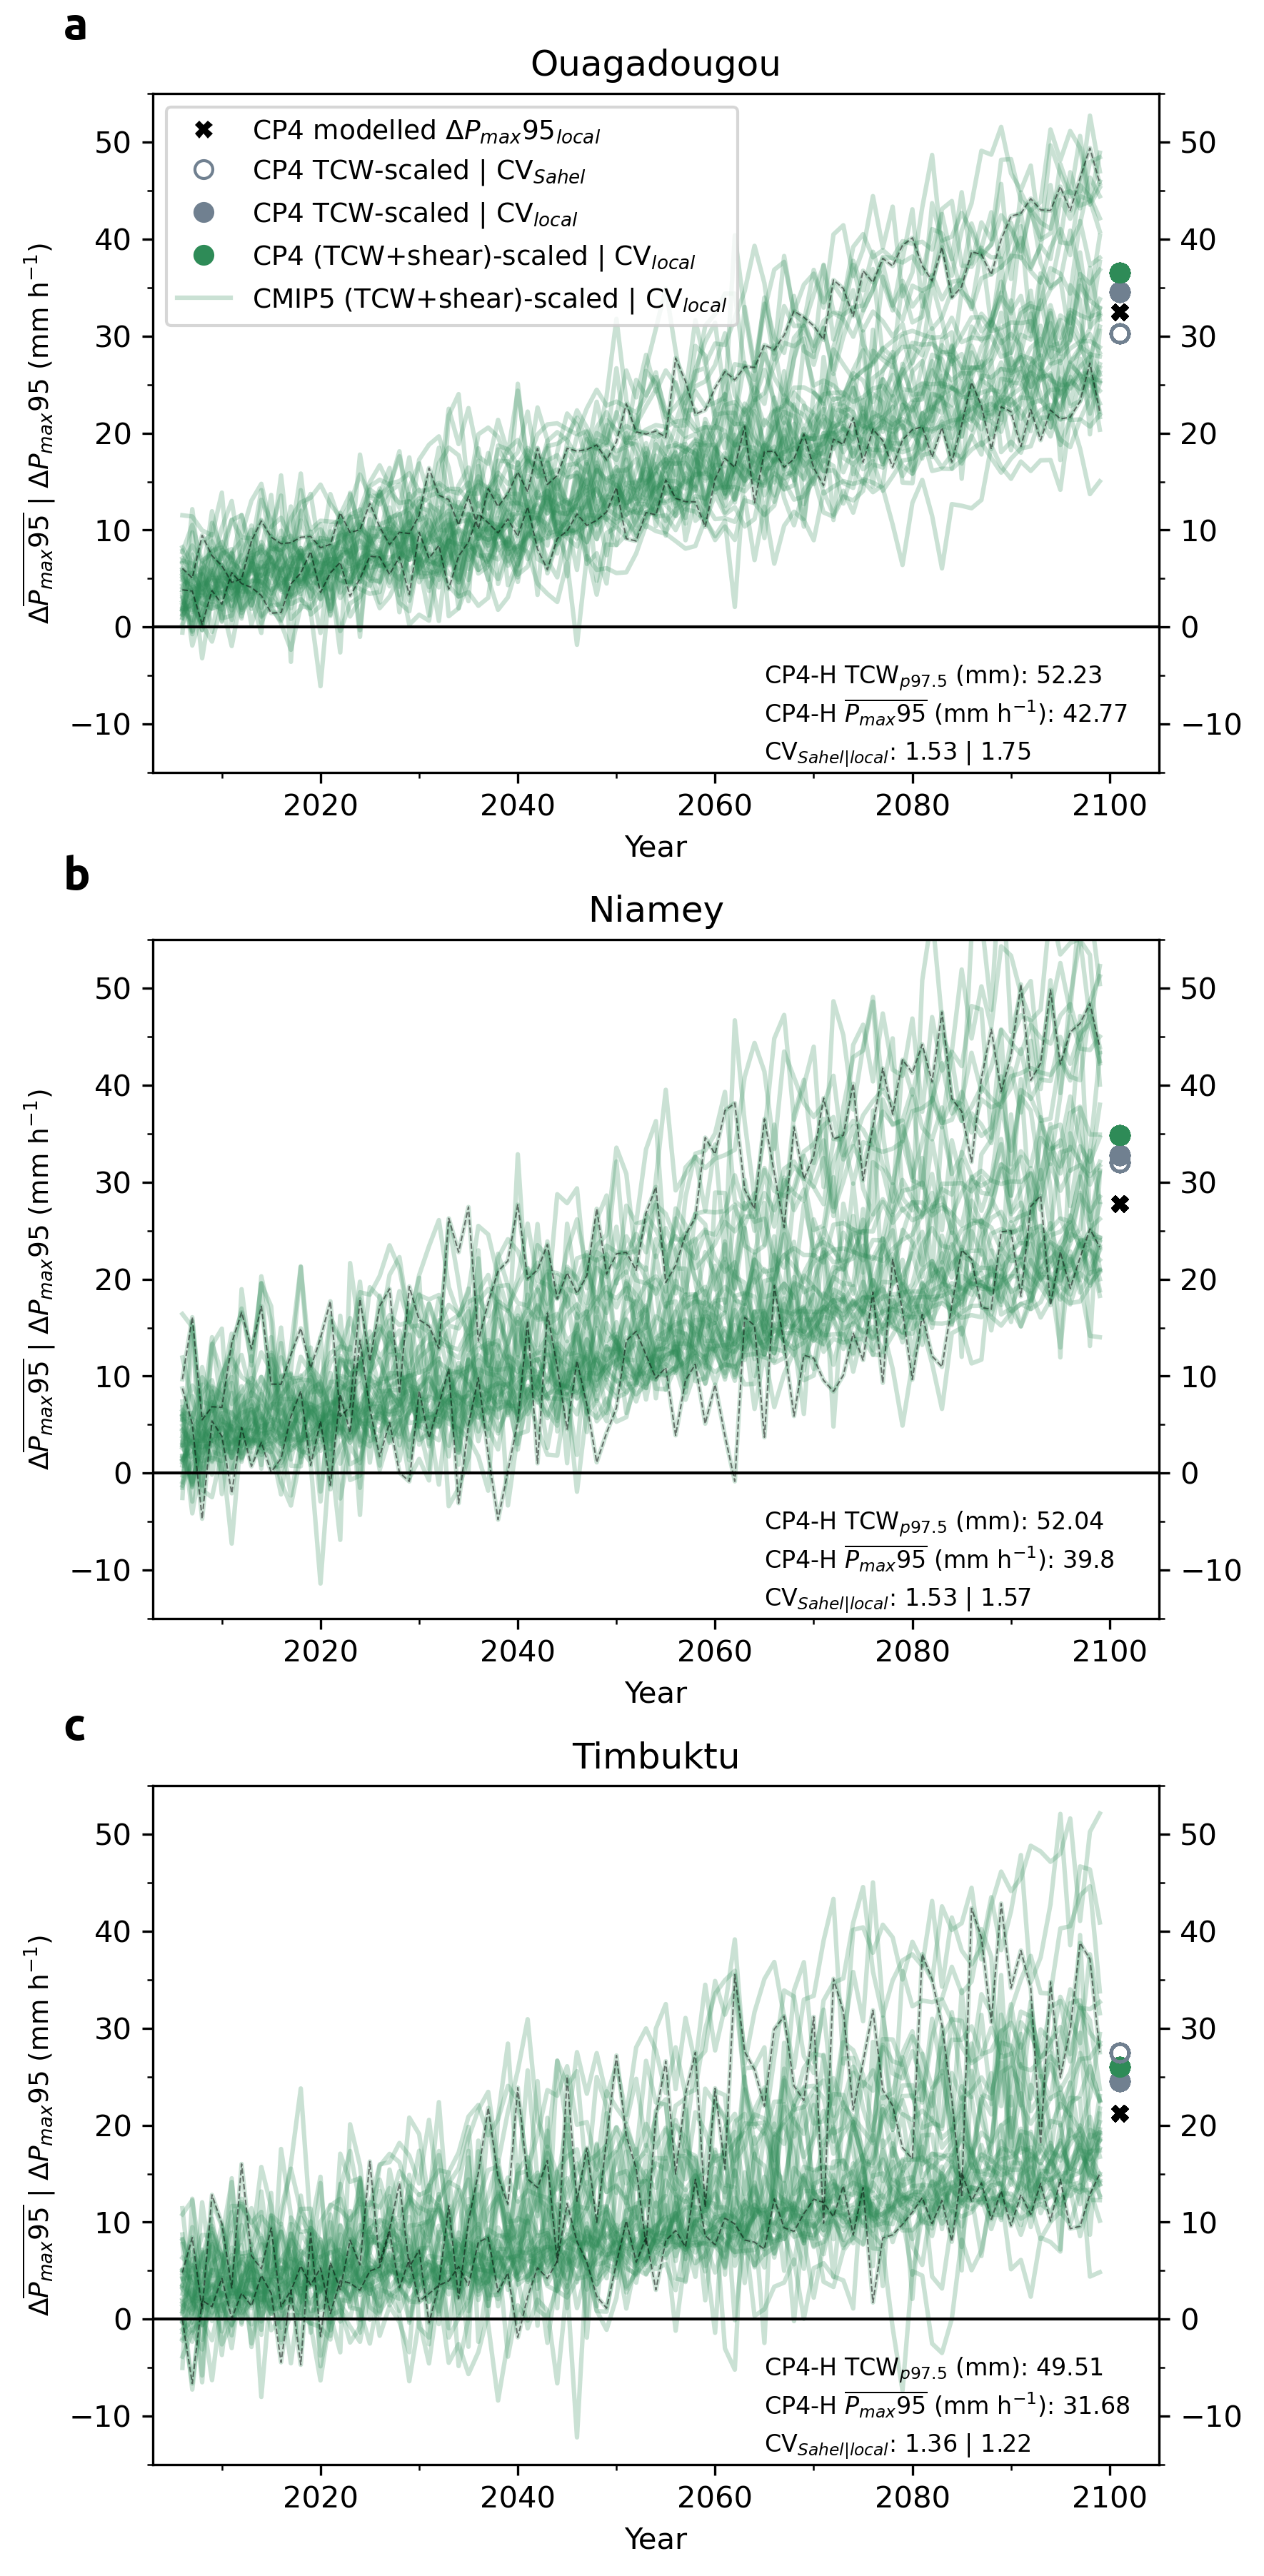

In [19]:
sahel = [-10,15,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}

f = plt.figure(figsize=(6,12), dpi=300)

for idss, rname in enumerate(['ouaga', 'niamey', 'timbuktu']):
    ax = f.add_subplot(3,1, idss+1)  #cp4f_mcs_grid-

    region = rname

    domain = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
    ftcw_sahel = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb")) #'+region+'
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_'+region+'.p', "rb")) #'+region+'

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['rel']) 
    precip_all = ftcw['prcp_hist']
    
    tcwvfac_all_sahel =  np.array(ftcw_sahel['rel']) 
    precip_all_sahel = ftcw_sahel['prcp_hist']

    dirs = regions
    cp4hist_mcs95, cp4fut_mcs95, obs_mcs95, cp4hist_mcs95_max, cp4fut_mcs95_max, obs_mcs95_max = calc_mcs(dirs[region][0])
    cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs = calc_regional(dirs[region][0])


    isclose = np.nanargmin(np.abs(cp4hist_mcs95['tcwv']-ftcw['tcw_hist']))
    isclose_sahel = np.nanargmin(np.abs(cp4hist_mcs95['tcwv']-ftcw_sahel['tcw_hist']))
    cp4_pos_array95 = tcwvfac_all[isclose]
    cp4_prcp_array95 = ftcw['prcp_hist'][isclose]
    cp4f_prcp_array95 = ftcw['prcp_fut'][isclose]
    
    cp4_pos_array95_sahel = tcwvfac_all_sahel[isclose_sahel]
    cp4_prcp_array95_sahel = ftcw_sahel['prcp_hist'][isclose_sahel]
    cp4f_prcp_array95_sahel = ftcw_sahel['prcp_fut'][isclose_sahel]

    slevels=np.arange(-18,19,3)

    yy ='2020-2100'

    evenly_spaced_interval = np.linspace(0, 1, len(model_names))

    colors = [cm.inferno(x) for x in evenly_spaced_interval]
    cmiplist = []
    cmipmean = []
    for ids, mn in enumerate(model_names.values):
        tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'_'+region+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
        sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'_'+region+'/u*_'+mn+'_*.nc')[0]).squeeze()

        tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
        sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)

        ##relative CMIP change
        ds_shear = sh_map['unknown']*shearfac
        cmip_rel = (tcw_map['prw']/tcw_map['prw_hist'])

        years = np.unique(tcw_map['time.year'].values)


        new_ar_list95 =   cmip_rel *cp4_pos_array95 * cp4hist_mcs95['prcp']
        sums95 = new_ar_list95 + ds_shear

#         cp4construct95 =  cp4hist_mcs95['prcp'] * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values
#         cp4construct95_sahel =  cp4hist_mcs95['prcp'] * cp4_pos_array95_sahel * cp4_tcw_rel['tcwv'].values
        
        cp4construct95 =  cp4_prcp_array95 * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values
        cp4construct95_sahel =  cp4_prcp_array95 * cp4_pos_array95_sahel * cp4_tcw_rel['tcwv'].values

        #obs_construct95 =  obs_mcs95['prcp'] * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values

        cp4total95 = cp4construct95 + cp4_shear_abs['u_pl']*shearfac
        cp4total95_sahel = cp4construct95 + cp4_shear_abs['u_pl']*shearfac

        
        cmiplist.append(sums95)
        cmipmean.append(np.mean(sums95[-30::]))
        #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
        #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')

        #ax.plot(2101, cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'], marker='X', linestyle='', mfc='b', label=r'CP4 modelled $\Delta P_{max}95_{local}$', zorder=99, mec='none')
        ax.plot(2101, cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'], marker='X', linestyle='', mfc='k', label=r'CP4 modelled $\Delta P_{max}95_{local}$', zorder=99, mec='none')
        ax.plot(2101, cp4construct95_sahel, marker='o', linestyle='', label=r'CP4 TCW-scaled | CV$_{Sahel}$', mfc='none', mec='slategrey', zorder=98)
        ax.plot(2101, cp4construct95, marker='o', linestyle='', color='slategrey', label=r'CP4 TCW-scaled | CV$_{local}$')
        ax.plot(2101, cp4total95, marker='o', linestyle='', color='seagreen', label=r'CP4 (TCW+shear)-scaled | CV$_{local}$')
       # ax.plot(2101, obs_construct95, marker='o', linestyle='', color='b', label=r'OBS TCW-constructed')
        #ax.errorbar(2101, cp4construct, yerr=np.array([[cp4construct-cp4construct05,cp4construct95-cp4construct]]).T, marker='o', color='slategrey', linestyle='', label=r'CP4 TCW-constructed')
        #ax.errorbar(2102, cp4total, yerr=np.array([[cp4total-cp4total05,cp4total95-cp4total]]).T, marker='o', color='seagreen', linestyle='', label=r'CP4 [TCW+Shear]-constructed')
        ax.plot(tcw_map['time.year'].values,sums95, color='seagreen', alpha=0.25, label=r'CMIP5 (TCW+shear)-scaled | CV$_{local}$')
        if (idss==0) & (ids==0):
            plt.legend(fontsize=9, loc='upper left')
        if ids == 0:
            print('TCWV rel', rname, (cp4_tcw_fut['tcwv'].values-cp4_tcw_hist['tcwv'].values)/cp4_tcw_hist['tcwv'].values, (cp4fut_mcs95['tcwv']-cp4hist_mcs95['tcwv'])/cp4hist_mcs95['tcwv'])
            print('TCWV ABS difference', rname, cp4_tcw_fut['tcwv'].values-cp4_tcw_hist['tcwv'].values, (cp4fut_mcs95['tcwv']-cp4hist_mcs95['tcwv']))
            print('TCWV hist', rname, cp4_tcw_hist['tcwv'].values,cp4hist_mcs95['tcwv'])
            print('PRCP', rname, (cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'])/cp4hist_mcs95['prcp'])
        #ipdb.set_trace()   
#         if rname == 'timbuktu':
#             ipdb.set_trace()
    meanordered = np.argsort(cmipmean)
    tsordered = np.array(cmiplist)[meanordered]
    pos90 = int(np.round(len(cmipmean)/100*90,0))
    pos10 = int(np.round(len(cmipmean)/100*10,0))
    
  
    ax.plot(tcw_map['time.year'].values,tsordered[pos10], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    ax.plot(tcw_map['time.year'].values,tsordered[pos90], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    
    print(np.median(tsordered[pos90][-30::]), np.median(tsordered[pos90][-30::])-np.median(tsordered[pos10][-30::]))
    
    

    ax.text(2065,-5.8,'CP4-H TCW$_{p97.5}$ (mm): '+str(np.round(cp4hist_mcs95['tcwv'],2)), fontsize=8)
    ax.text(2065,-9.8,'CP4-H $\overline{P_{max}95}$ (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95['prcp'],2)), fontsize=8)
    ax.text(2065,-13.7,'CV$_{Sahel | local}$: '+str(np.round(cp4_pos_array95_sahel,2))+' | '+str(np.round(cp4_pos_array95,2)), fontsize=8)
    ax.set_ylabel('$\Delta \overline{P_{max}95}$ | $\Delta P_{max}95$ (mm h$^{-1}$)', fontsize=9)
    ax.set_xlabel('Year')
    ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    ax.set_ylim(-15,55)
    ax.set_xlim(2003,2105)
    ax.set_title(city)
    
plt.tight_layout()

text = ['a', 'b', 'c']
plt.tight_layout()
plt.annotate(text[0], xy=(0.05, 0.98), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[1], xy=(0.05, 0.65), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[2], xy=(0.05, 0.32), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_all_cities_timeseries_CP4_0.1mm.jpg')

## 

TCWV rel ouaga 0.46091136 0.42884754574356837
TCWV ABS difference ouaga 21.224487 22.39867379090952
TCWV hist ouaga 46.048958 52.22992182938345
PRCP ouaga 0.7588530957388063


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

33.959484897686025 16.109442556977477
TCWV rel niamey 0.49940246 0.4236393237817544
TCWV ABS difference niamey 22.03357 22.04471693506234
TCWV hist niamey 44.119865 52.03652186551757
PRCP niamey 0.6975369352914068


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

40.075778365416994 23.11349753889776
TCWV rel timbuktu 0.54614025 0.43189302765959625
TCWV ABS difference timbuktu 19.580826 21.38181921670997
TCWV hist timbuktu 35.853107 49.50721092344749
PRCP timbuktu 0.6697325085124006


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

34.5487187209447 21.975733487624783


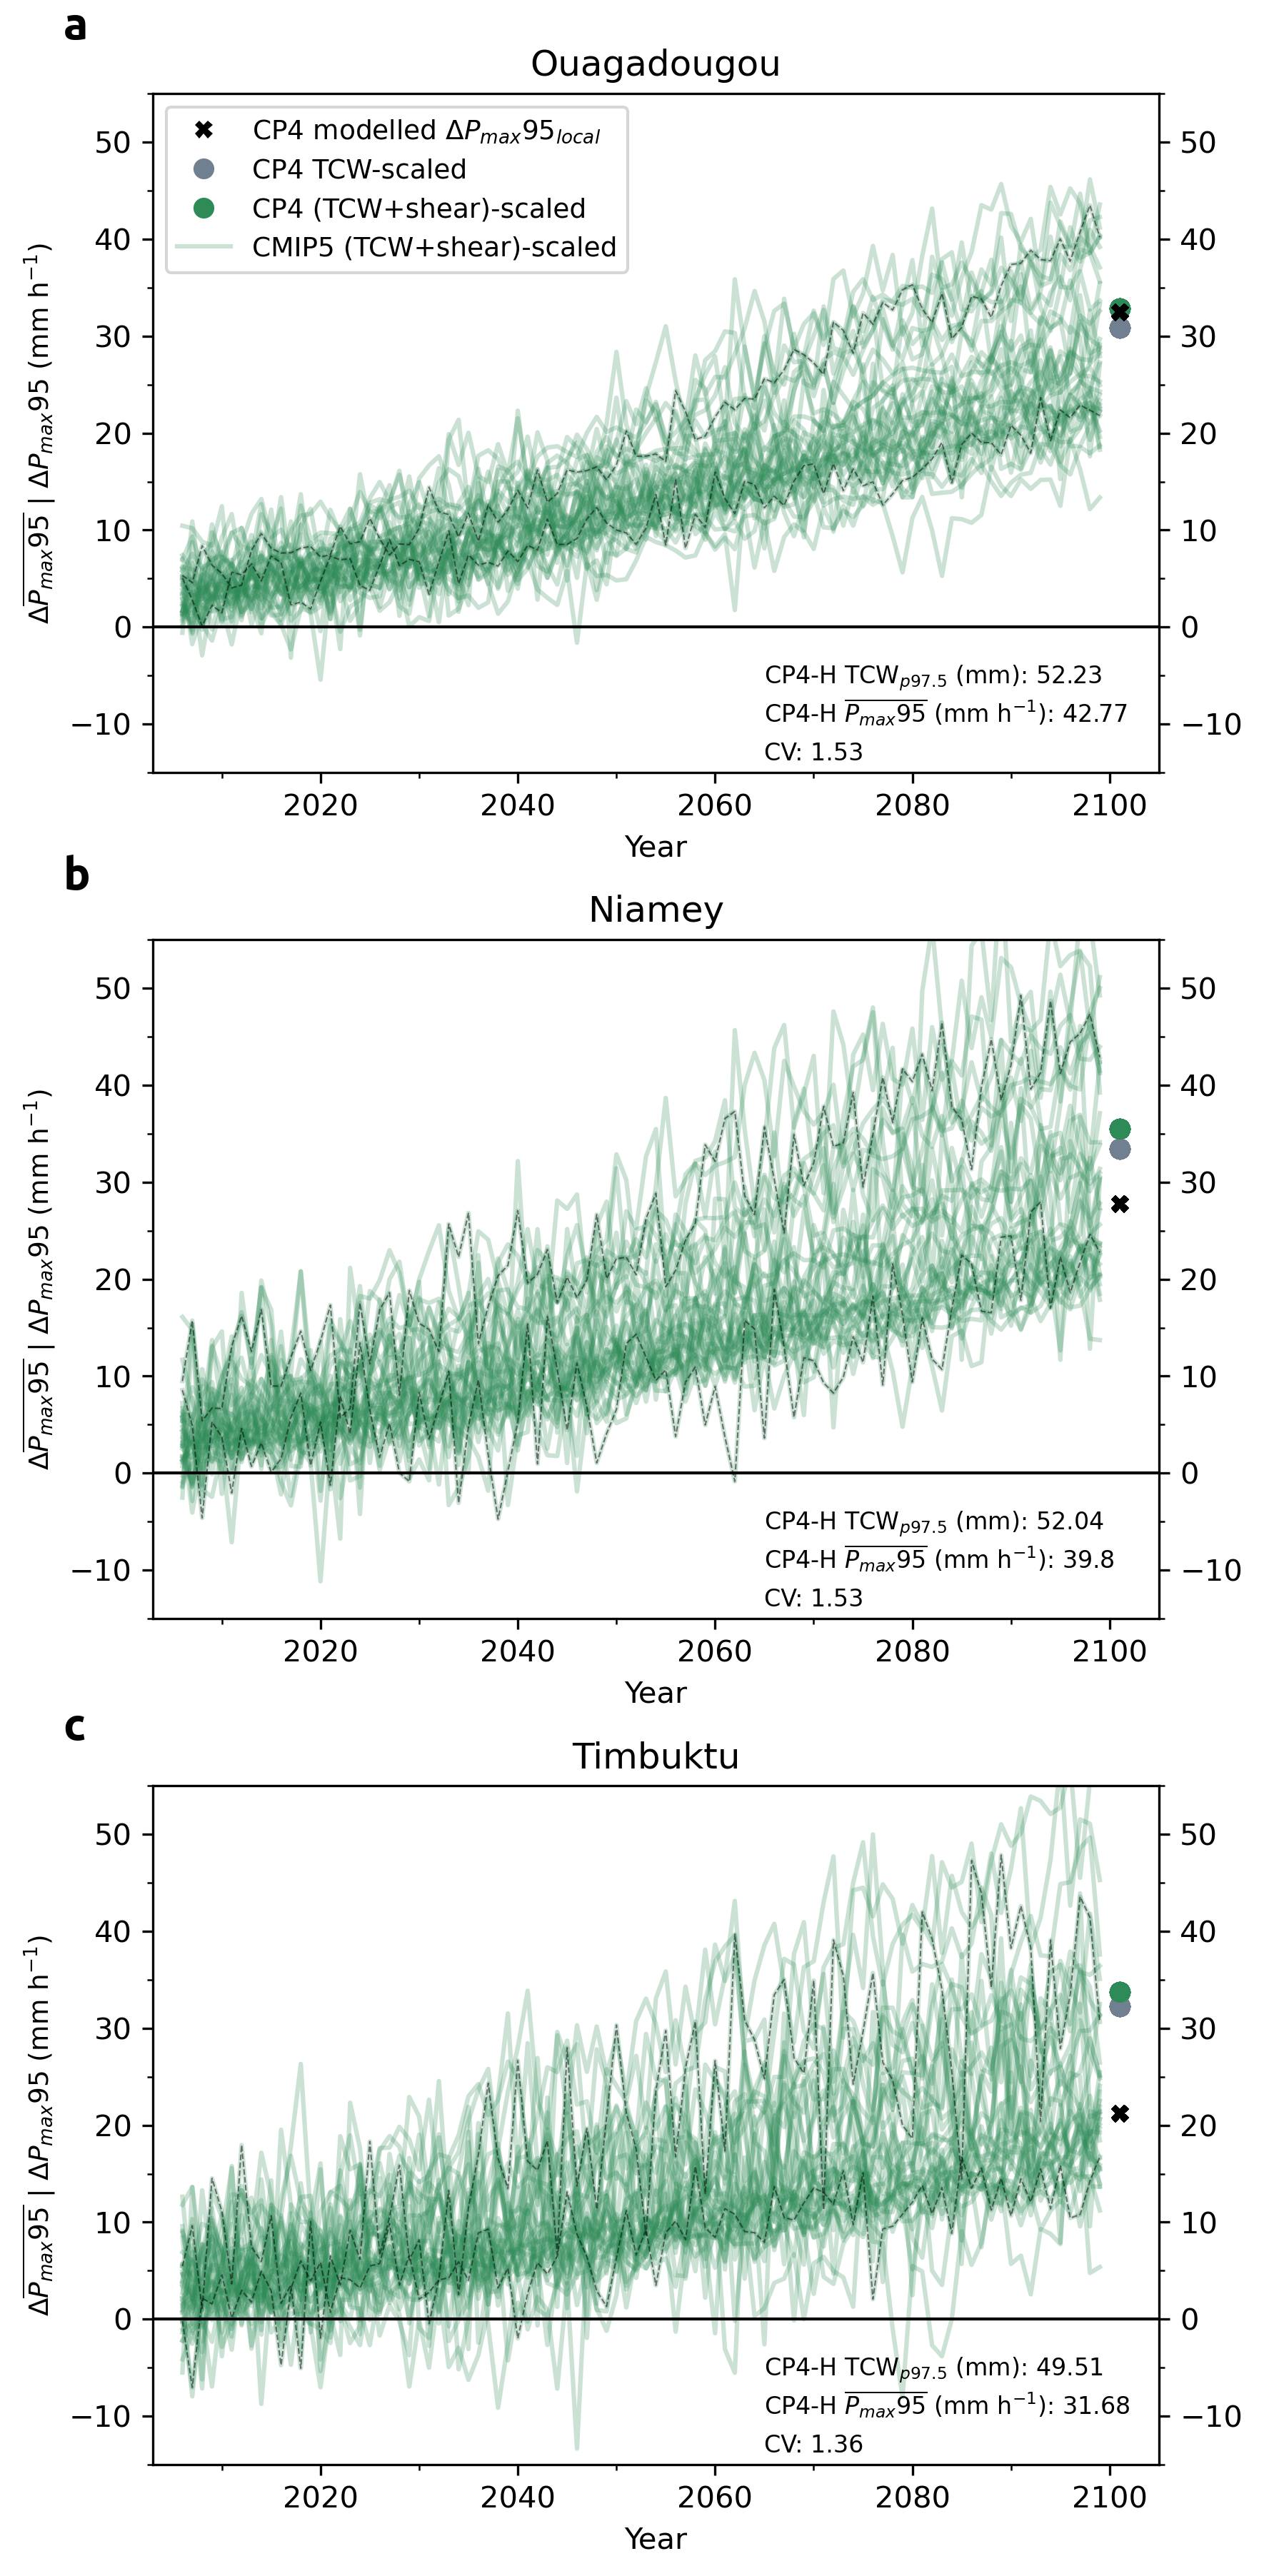

In [24]:
sahel = [-10,15,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}

f = plt.figure(figsize=(6,12), dpi=300)

for idss, rname in enumerate(['ouaga', 'niamey', 'timbuktu']):
    ax = f.add_subplot(3,1, idss+1)  #cp4f_mcs_grid-

    region = rname

    domain = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb")) #'+region+'

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['rel']) 
    precip_all = ftcw['prcp_hist']

    dirs = regions
    cp4hist_mcs95, cp4fut_mcs95, obs_mcs95, cp4hist_mcs95_max, cp4fut_mcs95_max, obs_mcs95_max = calc_mcs(dirs[region][0])
    cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs = calc_regional(dirs[region][0])


    isclose = np.nanargmin(np.abs(cp4hist_mcs95['tcwv']-ftcw['tcw_hist']))

    cp4_pos_array95 = tcwvfac_all[isclose]
    cp4_prcp_array95 = ftcw['prcp_hist'][isclose]
    cp4f_prcp_array95 = ftcw['prcp_fut'][isclose]

    slevels=np.arange(-18,19,3)

    yy ='2020-2100'

    evenly_spaced_interval = np.linspace(0, 1, len(model_names))

    colors = [cm.inferno(x) for x in evenly_spaced_interval]
    cmiplist = []
    cmipmean = []
    for ids, mn in enumerate(model_names.values):
        tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'_'+region+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
        sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'_'+region+'/u*_'+mn+'_*.nc')[0]).squeeze()

        tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
        sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)

        ##relative CMIP change
        ds_shear = sh_map['unknown']*shearfac
        cmip_rel = (tcw_map['prw']/tcw_map['prw_hist'])

        years = np.unique(tcw_map['time.year'].values)

        new_ar_list95 = cmip_rel *cp4_pos_array95 * cp4hist_mcs95['prcp']
        sums95 = new_ar_list95 + ds_shear
        
        cp4construct95 =  cp4_prcp_array95 * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values

        cp4total95 = cp4construct95 + cp4_shear_abs['u_pl']*shearfac
        
        cmiplist.append(sums95)
        cmipmean.append(np.mean(sums95[-30::]))

        ax.plot(2101, cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'], marker='X', linestyle='', mfc='k', label=r'CP4 modelled $\Delta P_{max}95_{local}$', zorder=99, mec='none')
        ax.plot(2101, cp4construct95, marker='o', linestyle='', color='slategrey', label=r'CP4 TCW-scaled')
        ax.plot(2101, cp4total95, marker='o', linestyle='', color='seagreen', label=r'CP4 (TCW+shear)-scaled')

        ax.plot(tcw_map['time.year'].values,sums95, color='seagreen', alpha=0.25, label=r'CMIP5 (TCW+shear)-scaled')
        if (idss==0) & (ids==0):
            plt.legend(fontsize=9, loc='upper left')
        if ids == 0:
            print('TCWV rel', rname, (cp4_tcw_fut['tcwv'].values-cp4_tcw_hist['tcwv'].values)/cp4_tcw_hist['tcwv'].values, (cp4fut_mcs95['tcwv']-cp4hist_mcs95['tcwv'])/cp4hist_mcs95['tcwv'])
            print('TCWV ABS difference', rname, cp4_tcw_fut['tcwv'].values-cp4_tcw_hist['tcwv'].values, (cp4fut_mcs95['tcwv']-cp4hist_mcs95['tcwv']))
            print('TCWV hist', rname, cp4_tcw_hist['tcwv'].values,cp4hist_mcs95['tcwv'])
            print('PRCP', rname, (cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'])/cp4hist_mcs95['prcp'])
        #ipdb.set_trace()   
#         if rname == 'timbuktu':
#             ipdb.set_trace()
    meanordered = np.argsort(cmipmean)
    tsordered = np.array(cmiplist)[meanordered]
    pos90 = int(np.round(len(cmipmean)/100*90,0))
    pos10 = int(np.round(len(cmipmean)/100*10,0))
    
  
    ax.plot(tcw_map['time.year'].values,tsordered[pos10], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    ax.plot(tcw_map['time.year'].values,tsordered[pos90], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    
    print(np.median(tsordered[pos90][-30::]), np.median(tsordered[pos90][-30::])-np.median(tsordered[pos10][-30::]))
    

    ax.text(2065,-5.8,'CP4-H TCW$_{p97.5}$ (mm): '+str(np.round(cp4hist_mcs95['tcwv'],2)), fontsize=8)
    ax.text(2065,-9.8,'CP4-H $\overline{P_{max}95}$ (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95['prcp'],2)), fontsize=8)
    ax.text(2065,-13.7,'CV: '+str(np.round(cp4_pos_array95,2)), fontsize=8)
    ax.set_ylabel('$\Delta \overline{P_{max}95}$ | $\Delta P_{max}95$ (mm h$^{-1}$)', fontsize=9)
    ax.set_xlabel('Year')
    ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    ax.set_ylim(-15,55)
    ax.set_xlim(2003,2105)
    ax.set_title(city)
    
plt.tight_layout()

text = ['a', 'b', 'c']
plt.tight_layout()
plt.annotate(text[0], xy=(0.05, 0.98), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[1], xy=(0.05, 0.65), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[2], xy=(0.05, 0.32), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_all_cities_timeseries_CP4_0.1mm_sahel.jpg')